In [0]:
import glob
import json
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

warnings.simplefilter(action='ignore', category=FutureWarning)


csv_files = glob.glob('data/movies_*.csv')

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)
    
movie = pd.concat(dfs)
movie = movie.drop_duplicates().reset_index(drop=True)

movie.shape


#movie = pd.read_csv("https://raw.githubusercontent.com/fescobar96/flixable_ml_dsi/master/data/movies_2020_01_23_13_15_04.csv")

## Data Cleaning

In [0]:
def str_get_dummies(df, columns, sep=',', drop_first=False, prefix=None, prefix_sep='_'):
    """Wrapper of pd.Series.str.get_dummies() to behave like pd.get_dummies()"""
    for p, col in zip(prefix, columns):
        str_dummy_df = df[col].str.get_dummies(sep=sep)
        
        if prefix is not None:
            prefixed_cols = [prefix_sep.join([p, c]) for c in str_dummy_df.columns]
            str_dummy_df.columns = prefixed_cols
        
        if drop_first:
            first_col = str_dummy_df.columns[0]
            str_dummy_df = str_dummy_df.drop(columns=[first_col])
        
        df = df.drop(columns=[col])
        df = pd.concat((df, str_dummy_df), axis=1)

    return df


def extract_rotten_rating(rating_list):
    """Extract info from ratings column using pd.Series.apply()"""
    try:
        ratings = json.loads(rating_list.replace("'", '"'))
        for rating in ratings:
            if rating['Source'] == 'Rotten Tomatoes':
                return float(rating['Value'].replace('%', ''))
    except AttributeError:
        return np.nan

In [0]:
# Custom function to extract rotten tomatoes ratings
movie['rotten_tomatoes'] = movie['Ratings'].apply(extract_rotten_rating)

# Convert numeric columns stored as strings
movie['Runtime'] = pd.to_numeric(movie['Runtime'].str.split(' ').str[0])
movie['BoxOffice'] = pd.to_numeric(movie['BoxOffice'].str.replace(r'[\$,]', ''))
movie['imdbVotes'] = pd.to_numeric(movie['imdbVotes'].str.replace(',', ''))

# Convert datetime columns stored as strings
movie['Released'] = pd.to_datetime(movie['Released'])
movie['added_to_netflix'] = pd.to_datetime(movie['added_to_netflix'])
movie['added_to_netflix_year'] = movie['added_to_netflix'].dt.year

# Extract numbers from Awards columns
movie['award_wins'] = movie['Awards'].str.extract(r'(\d) win').astype(float)
movie['award_noms'] = movie['Awards'].str.extract(r'(\d) nomination').astype(float)
movie['oscar_wins'] = movie['Awards'].str.extract(r'Nominated for (\d) Oscar').astype(float)

award_cols = ['award_wins', 'award_noms', 'oscar_wins']
movie[award_cols] = movie[award_cols].fillna(0)

In [0]:
drop_columns = ['Poster', 'flixable_url', 'Response', 
                'Awards', 'Rated', 'imdbID', 'DVD', 'Website',
                'BoxOffice', 'Released', 'added_to_netflix',
                'Writer', 'Actors', 'Plot',
                'rotten_tomatoes', 'Metascore', 'Production',
                'totalSeasons', 'Runtime', 'Director',
                'Title', 'Ratings']

movie = movie.drop(columns=drop_columns)

In [0]:
list_cols = ['Genre', 'Language', 'Country']

movie_dummy = str_get_dummies(movie, 
                              columns=list_cols, 
                              sep=', ', 
                              prefix=list_cols, 
                              drop_first=False)

In [0]:
movie_dummy = movie_dummy.dropna(subset=['imdbRating'])

In [9]:
movie_dummy.isna().mean().sort_values(ascending=False)

Country_Zimbabwe                  0.0
Language_Hokkien                  0.0
Language_Kriolu                   0.0
Language_Korean                   0.0
Language_Khmer                    0.0
                                 ... 
Country_Bosnia and Herzegovina    0.0
Country_Bermuda                   0.0
Country_Belgium                   0.0
Country_Bangladesh                0.0
Type                              0.0
Length: 271, dtype: float64

## EDA

In [0]:
def barplot_dummies(df, prefix, max_n=15):
    cols = [c for c in df if c.startswith(prefix)]
    counts = df[cols].sum().sort_values(ascending=False)
    counts = counts[:max_n]
    counts.index = [i.replace(prefix, '') for i in counts.index]
    counts.plot.barh()
    plt.title(prefix)
    plt.show()

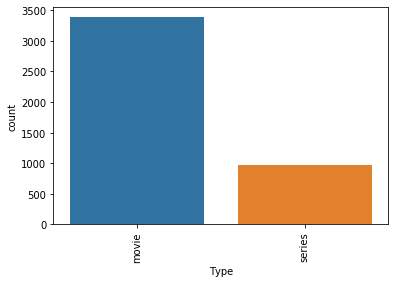

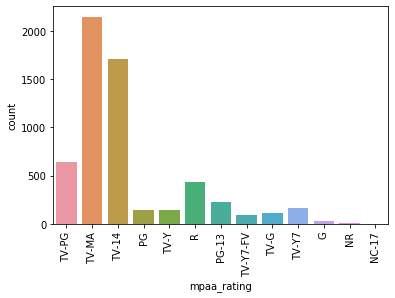

In [11]:
plot_cols = ['Type', 'mpaa_rating']
for plot_col in plot_cols:
    fig = sns.countplot(plot_col, data=movie)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    plt.show()

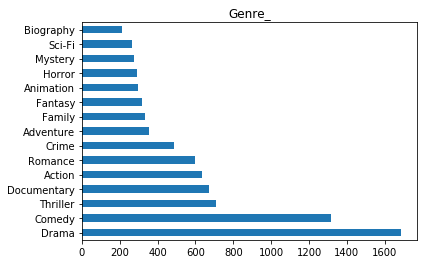

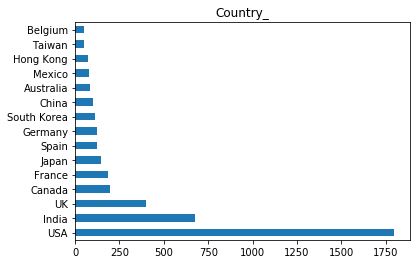

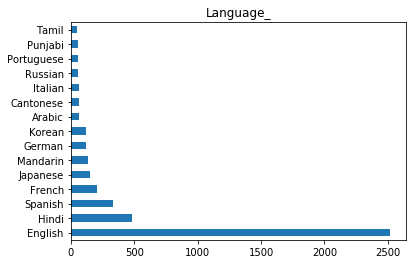

In [12]:
prefixes = ['Genre_', 'Country_', 'Language_']
for prefix in prefixes:
    barplot_dummies(movie_dummy, prefix)

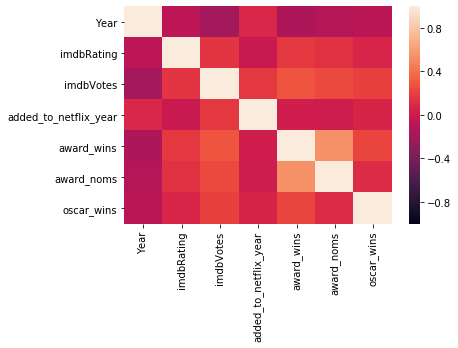

In [13]:
sns.heatmap(movie.corr(), vmin=-1, vmax=1)
plt.show()

In [38]:
movie_countries = movie[pd.notnull(movie["Country"])]
movie_countries.head()

,Country,Genre,Language,Type,Year,imdbRating,imdbVotes,mpaa_rating,added_to_netflix_year,award_wins,award_noms,oscar_wins
0,Brazil,"Comedy, Romance",NaN,movie,2020.0,NaN,NaN,TV-PG,2020.0,0.0,0.0,0.0
1,Mexico,Comedy,Spanish,movie,2020.0,NaN,NaN,TV-MA,2020.0,0.0,0.0,0.0
6,USA,Documentary,English,movie,1968.0,7.5,153.0,TV-14,2020.0,0.0,0.0,0.0
7,USA,Documentary,English,series,2020.0,NaN,NaN,TV-14,2020.0,0.0,0.0,0.0
8,USA,"Comedy, Family",English,movie,2019.0,4.7,2557.0,TV-MA,2020.0,0.0,0.0,0.0


In [63]:
data = movie_countries.groupby("added_to_netflix_year")["Country"].value_counts(normalize=True).reset_index(name="Percentage")
data["Percentage"] = data["Percentage"] * 100
data["added_to_netflix_year"] = data["added_to_netflix_year"].astype("int")
data.head()

,added_to_netflix_year,Country,Percentage
0,2008,USA,100.000000
1,2009,Denmark,50.000000
2,2009,USA,50.000000
3,2010,USA,100.000000
4,2011,USA,90.909091


In [64]:
fig = px.choropleth(data, locations="Country", color="Percentage", 
                    locationmode="country names",
                    animation_frame="added_to_netflix_year",
                    range_color=[0,100],
                   )

fig.update_layout(title="Percentage of Content Added to Netflix by Country")
fig.show()

## Model Prep

In [0]:
movie_dummy = str_get_dummies(movie, 
                              columns=list_cols, 
                              sep=', ', 
                              prefix=list_cols, 
                              drop_first=True)

movie_dummy = pd.get_dummies(movie_dummy,
                             columns=['Type', 'mpaa_rating'],
                             drop_first=True)

In [15]:
movie_dummy = movie_dummy.dropna()
movie_dummy.shape

(4061, 279)

In [0]:
y_col = 'imdbRating'
X = movie_dummy.drop(columns=[y_col])
y = movie_dummy[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [22]:
parameters = {
    "learning_rate":[0.01],
    "n_estimators":[1000],
    "max_depth":[3],
    "subsample":[0.8],
    "colsample_bytree":[1],
    "gamma":[1]
}
xgb = GridSearchCV(XGBRegressor(objective="reg:squarederror"), param_grid=parameters, verbose=2)
xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, total=  16.8s
[CV] colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


[CV]  colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, total=  16.9s
[CV] colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 
[CV]  colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, total=  17.0s
[CV] colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 
[CV]  colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, total=  17.0s
[CV] colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 
[CV]  colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, total=  17.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [1], 'gamma': [1],
                         'learning_rate': [0.01], 'max_dept

In [23]:
train_score = xgb.score(X_train, y_train)
test_score = xgb.score(X_test, y_test)

print(f'Train score: {train_score:.2f}')
print(f'Test score: {test_score:.2f}')

Train score: 0.45
Test score: 0.40


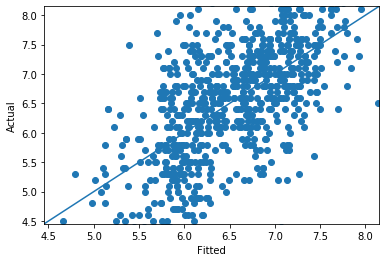

In [28]:
y_pred = xgb.predict(X_test)

min_pred = min(y_pred)
max_pred = max(y_pred)
x = [min_pred, max_pred]
y = [min_pred, max_pred]

plt.scatter(y_pred, y_test)
plt.plot(x, y)
plt.xlabel('Fitted')
plt.ylabel('Actual')
plt.xlim((min_pred, max_pred))
plt.ylim((min_pred, max_pred))
plt.show()